# Cas de prédiction du Loto français 

In [1]:
#Import des librairies utiles
from bs4 import BeautifulSoup
from pymongo import MongoClient
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping
from datetime import date



## Fonction de scraping des tirages

In [2]:
#fonction de scraping des tirages du loto
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

In [3]:
#A noter que plusieurs tirages se sont ajoutés dépuis le 21 : date de rédaction de l'article

In [4]:
#sracping des tirages actuellement disponibles sur le site 
df_tirage=scrap_loto_numbers()
df_tirage[['day','month_year','num0','num1','num2','num3','num4','chance']].head()
#suppression  des tirages du super loto( A explorer later )
#df_tirage=df_tirage[(df_tirage['day']!='Vendredi') & (df_tirage['day']!='Mardi')]

,day,month_year,num0,num1,num2,num3,num4,chance
0,Samedi,02 octobre 2021,6,8,20,35,46,9
1,Mercredi,29 septembre 2021,6,13,28,33,39,10
2,Lundi,27 septembre 2021,12,26,31,37,40,3
3,Samedi,25 septembre 2021,16,18,20,35,49,1
4,Mercredi,22 septembre 2021,5,9,13,14,40,1


In [5]:
#df_tirage=df_tirage.tail(df_tirage.shape[0]-1)

## commentaires: 
* le dernier tirage ici date du 07 décembre, ainsi afin de tester le modèle nous allons rétirer ce tirage du dataset dans la suite
* Par contre on aurait évité de supprimer le tirage du 28 si on voulait prédire le prochain tirage ( celui du samedi 31)

In [6]:
#df_tirage=df_tirage.tail(df_tirage.shape[0])# suppression du dernier tirage/à éviter selon le cas 
df_tirage.head()# le dernier tirage devient ici celui du 26

,day,month_year,num0,num1,num2,num3,num4,chance
0,Samedi,02 octobre 2021,6,8,20,35,46,9
1,Mercredi,29 septembre 2021,6,13,28,33,39,10
2,Lundi,27 septembre 2021,12,26,31,37,40,3
3,Samedi,25 septembre 2021,16,18,20,35,49,1
4,Mercredi,22 septembre 2021,5,9,13,14,40,1


## Traitement  des données

In [7]:
df = df_tirage.iloc[::-1]#inversion du dataframe pour placer le dernier tirage en dernière position
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]#sélection des numéros à  traiter

In [8]:
df.tail()# notre tirage du 26 ici devient le dernier de notre dataset afin de pourvoir organiser les data par historique

,num0,num1,num2,num3,num4,chance
4,5,9,13,14,40,1
3,16,18,20,35,49,1
2,12,26,31,37,40,3
1,6,13,28,33,39,10
0,6,8,20,35,46,9


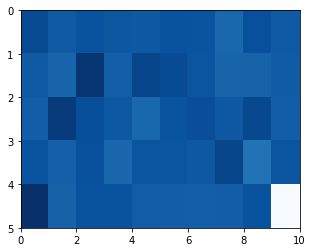

In [9]:


#fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, sauf celui de chance
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

#fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

#fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return (data['chance'].isin(pairs)).astype(int)

#fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return (data['chance'].isin(impairs)).astype(int)

#liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

#Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)


# Calcul de la fréquence de tirage de chaque numéro
freqs = []
for val in range(50):
    count = ( (df['num0'] == val+1).sum() +
              (df['num1'] == val+1).sum() +
              (df['num2'] == val+1).sum() +
              (df['num3'] == val+1).sum() +
              (df['num4'] == val+1).sum() )
    freqs.append(count)
ax = plt.gca() ;  ax.invert_yaxis()
plt.gcf().set_size_inches(5, 4)
heatmap = plt.pcolor(np.reshape(np.array(freqs), (5, 10)), cmap=plt.cm.Blues)

def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs



#df['sum'] = ((df.num0 + df.num1 + df.num2 + df.num3 + df.num4 + df.chance ) >185).astype(int)


In [10]:
#ajout de la difference entre les numéros(A explorer ASAp)
#for i in range(4):
    #print(i,i+1)
    #df['diff_{}'.format(i)]=df['num{}'.format(i+1)]-df['num{}'.format(i)]
#application des fonctions sur le dataframe
df['freq_num0'] = freq_val(df, 'num0')
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance')#calcul des frequences 
df['sum_diff'] = sum_diff(df)#somme de la différence au carré entre chaque couple de numéros successifs dans le tirage
df['pair_chance'] = is_pair_etoile(df)
df['impair_chance'] = is_impair_etoile(df)
df['pair'] = is_pair(df)
df['impair'] = is_impair(df)#verification de nombre pair et impair
df['is_under_24'] = is_under(df, 24)  # Les numeros en dessous de 24 
df['is_under_40'] = is_under(df, 40)# Les numeros en dessous de 40 
df.head(6)

,num0,num1,num2,num3,num4,chance,freq_num0,freq_num1,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,is_under_24,is_under_40
2074,19,24,27,33,41,9,1,1,1,1,1,1,134,0,1,1,4,2,4
2073,22,24,32,41,48,1,1,2,1,1,1,1,198,0,1,4,1,2,3
2072,10,20,22,39,46,4,1,1,1,1,1,1,442,1,0,4,1,3,4
2071,10,11,37,41,48,4,2,1,1,2,2,2,742,1,0,2,3,2,3
2070,18,20,28,40,49,1,1,2,1,1,1,2,293,0,1,4,1,2,4
2069,4,32,35,39,44,10,1,1,1,2,1,1,834,1,0,3,2,1,4


## Modèle et fonction de formatage des données en entrée du LSTM

In [11]:
#capture 3: fonction define model seulement

In [12]:
# j'ai ici défini plusieurs modèles à tester mais pour l'intant je tavaille avec le lstm(fonction : define_model)
# j'ai ici défini window_length à 12 pour apprendre sur 1 mois de données 

#Params du modèle
nb_label_feature=6

UNITS = 100
BATCHSIZE = 30
EPOCH = 1500
#ACTIVATION = "softmax"
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae'#'categorical_crossentropy' #mse
DROPOUT = 0.1
window_length =12 #12 
number_of_features = df.shape[1]

#Architecture du modèle
def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.1, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model



#model = define_model(number_of_features,nb_label_feature)
#model3 = define_autoencoder_model(number_of_features,nb_label_feature)
#model4 = define_bidirectionnel_model(number_of_features,nb_label_feature)

#Moniteur pour stoper le training
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=100)

In [13]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm  
    model = define_model(number_of_features,nb_label_feature)
        
    return train, label, model,scaler

## Training

In [14]:
#formatage des données
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)
 

(2063, 12, 19)
(2063, 6)


* On voit ici que notre dataset d'entrainement après formatage est constitué de 1911 vecteurs contenant chacun 12 tirages où chaque tirage contient 19 features calculés plus haut

* Quant aux labels, on a bien 1911 vecteurs de 6 features soit les 6 numéros de chaque tirages

* Ainsi à partir des 12 tirages précédent on éssaie de prédire le tirage suivant lors de l'entrainement

In [15]:
#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2, callbacks=[es])

Epoch 1/1500
69/69 - 3s - loss: 0.8137 - acc: 0.1474
Epoch 2/1500
69/69 - 1s - loss: 0.8072 - acc: 0.1561
Epoch 3/1500
69/69 - 1s - loss: 0.8058 - acc: 0.1604
Epoch 4/1500
69/69 - 1s - loss: 0.8028 - acc: 0.1561
Epoch 5/1500
69/69 - 1s - loss: 0.8010 - acc: 0.1813
Epoch 6/1500
69/69 - 1s - loss: 0.7978 - acc: 0.1706
Epoch 7/1500
69/69 - 1s - loss: 0.7949 - acc: 0.1866
Epoch 8/1500
69/69 - 1s - loss: 0.7886 - acc: 0.1958
Epoch 9/1500
69/69 - 1s - loss: 0.7853 - acc: 0.1949
Epoch 10/1500
69/69 - 1s - loss: 0.7771 - acc: 0.2196
Epoch 11/1500
69/69 - 1s - loss: 0.7692 - acc: 0.2269
Epoch 12/1500
69/69 - 1s - loss: 0.7590 - acc: 0.2172
Epoch 13/1500
69/69 - 1s - loss: 0.7452 - acc: 0.2399
Epoch 14/1500
69/69 - 1s - loss: 0.7312 - acc: 0.2593
Epoch 15/1500
69/69 - 1s - loss: 0.7156 - acc: 0.2700
Epoch 16/1500
69/69 - 1s - loss: 0.7038 - acc: 0.2700
Epoch 17/1500
69/69 - 1s - loss: 0.6801 - acc: 0.2908
Epoch 18/1500
69/69 - 1s - loss: 0.6668 - acc: 0.3000
Epoch 19/1500
69/69 - 1s - loss: 0.64

Epoch 152/1500
69/69 - 1s - loss: 0.1373 - acc: 0.8623
Epoch 153/1500
69/69 - 1s - loss: 0.1386 - acc: 0.8638
Epoch 154/1500
69/69 - 1s - loss: 0.1358 - acc: 0.8614
Epoch 155/1500
69/69 - 1s - loss: 0.1386 - acc: 0.8667
Epoch 156/1500
69/69 - 1s - loss: 0.1352 - acc: 0.8759
Epoch 157/1500
69/69 - 1s - loss: 0.1355 - acc: 0.8691
Epoch 158/1500
69/69 - 1s - loss: 0.1378 - acc: 0.8522
Epoch 159/1500
69/69 - 1s - loss: 0.1371 - acc: 0.8730
Epoch 160/1500
69/69 - 1s - loss: 0.1346 - acc: 0.8822
Epoch 161/1500
69/69 - 1s - loss: 0.1341 - acc: 0.8691
Epoch 162/1500
69/69 - 1s - loss: 0.1326 - acc: 0.8652
Epoch 163/1500
69/69 - 1s - loss: 0.1336 - acc: 0.8735
Epoch 164/1500
69/69 - 1s - loss: 0.1324 - acc: 0.8793
Epoch 165/1500
69/69 - 1s - loss: 0.1321 - acc: 0.8783
Epoch 166/1500
69/69 - 1s - loss: 0.1316 - acc: 0.8749
Epoch 167/1500
69/69 - 1s - loss: 0.1317 - acc: 0.8701
Epoch 168/1500
69/69 - 1s - loss: 0.1330 - acc: 0.8594
Epoch 169/1500
69/69 - 1s - loss: 0.1322 - acc: 0.8657
Epoch 170/

Epoch 301/1500
69/69 - 1s - loss: 0.1042 - acc: 0.8972
Epoch 302/1500
69/69 - 1s - loss: 0.1065 - acc: 0.9006
Epoch 303/1500
69/69 - 1s - loss: 0.1029 - acc: 0.9006
Epoch 304/1500
69/69 - 1s - loss: 0.1036 - acc: 0.8919
Epoch 305/1500
69/69 - 1s - loss: 0.1048 - acc: 0.9079
Epoch 306/1500
69/69 - 1s - loss: 0.1025 - acc: 0.8987
Epoch 307/1500
69/69 - 1s - loss: 0.1036 - acc: 0.8977
Epoch 308/1500
69/69 - 1s - loss: 0.1040 - acc: 0.9006
Epoch 309/1500
69/69 - 1s - loss: 0.1035 - acc: 0.8992
Epoch 310/1500
69/69 - 1s - loss: 0.1026 - acc: 0.8997
Epoch 311/1500
69/69 - 1s - loss: 0.1025 - acc: 0.8943
Epoch 312/1500
69/69 - 1s - loss: 0.1025 - acc: 0.8943
Epoch 313/1500
69/69 - 1s - loss: 0.1039 - acc: 0.9064
Epoch 314/1500
69/69 - 1s - loss: 0.1016 - acc: 0.9064
Epoch 315/1500
69/69 - 1s - loss: 0.1019 - acc: 0.8890
Epoch 316/1500
69/69 - 1s - loss: 0.1011 - acc: 0.8968
Epoch 317/1500
69/69 - 1s - loss: 0.1008 - acc: 0.8968
Epoch 318/1500
69/69 - 1s - loss: 0.1018 - acc: 0.8992
Epoch 319/

Epoch 450/1500
69/69 - 1s - loss: 0.0903 - acc: 0.9176
Epoch 451/1500
69/69 - 1s - loss: 0.0888 - acc: 0.9084
Epoch 452/1500
69/69 - 1s - loss: 0.0885 - acc: 0.9142
Epoch 453/1500
69/69 - 1s - loss: 0.0899 - acc: 0.9094
Epoch 454/1500
69/69 - 1s - loss: 0.0901 - acc: 0.9103
Epoch 455/1500
69/69 - 1s - loss: 0.0896 - acc: 0.9147
Epoch 456/1500
69/69 - 1s - loss: 0.0884 - acc: 0.9161
Epoch 457/1500
69/69 - 1s - loss: 0.0890 - acc: 0.9142
Epoch 458/1500
69/69 - 1s - loss: 0.0879 - acc: 0.9157
Epoch 459/1500
69/69 - 1s - loss: 0.0884 - acc: 0.9021
Epoch 460/1500
69/69 - 1s - loss: 0.0890 - acc: 0.9171
Epoch 461/1500
69/69 - 1s - loss: 0.0889 - acc: 0.9186
Epoch 462/1500
69/69 - 1s - loss: 0.0903 - acc: 0.9050
Epoch 463/1500
69/69 - 1s - loss: 0.0877 - acc: 0.9108
Epoch 464/1500
69/69 - 1s - loss: 0.0902 - acc: 0.9123
Epoch 465/1500
69/69 - 1s - loss: 0.0889 - acc: 0.9098
Epoch 466/1500
69/69 - 1s - loss: 0.0874 - acc: 0.9060
Epoch 467/1500
69/69 - 1s - loss: 0.0882 - acc: 0.9074
Epoch 468/

## Fonction de perte 

In [16]:
#capture 6

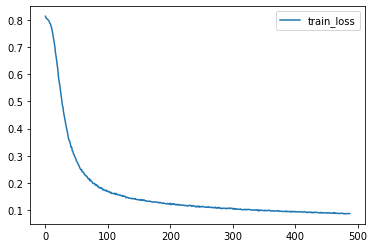

In [17]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

## Prédiction du tirage suivant le dernier tirage de notre dataset de train

In [18]:
#Prediction basée sur les 12 derniers tirages
last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

In [27]:
#prediction
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)

#block code added by bastien mathou
#try to insert data in mongo 
#please verify the good url fo mongodb
client = MongoClient("mongodb://localhost:27017")
dbConnection=client.prediction
collection = dbConnection.lotoPrediction

#prepare data for insertion
today = date.today()
prediction= scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0]
prediction = {
    "date": today.strftime("%d/%m/%Y"),
    "1nb":str(prediction[0]),
    "2nb":str(prediction[1]),
    "3nb":str(prediction[2]),
    "4nb":str(prediction[3]),
    "5nb":str(prediction[4]),
    "chanceNb":str(prediction[5])
}

#insertion
result=collection.insert_one(prediction)
client.close()

print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])

[ 6  9 20 30 48  4]
